In [1]:
import numpy as np
import pandas as pd 

import copy

np.random.seed(0) 
import random

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from scipy.io import loadmat

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn")

In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## Model with VGG-19 Arhcitecture on SVHN + GTSRB datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру, але без використання Early-Exit блоку.

### Модель
У цьому ноутбуці продемонстровано результати виконання моделі на основі VGG-19 архітектури для їхнього порівняння з результатами розробленої моделі з впровадженим Early-Exit блоком.

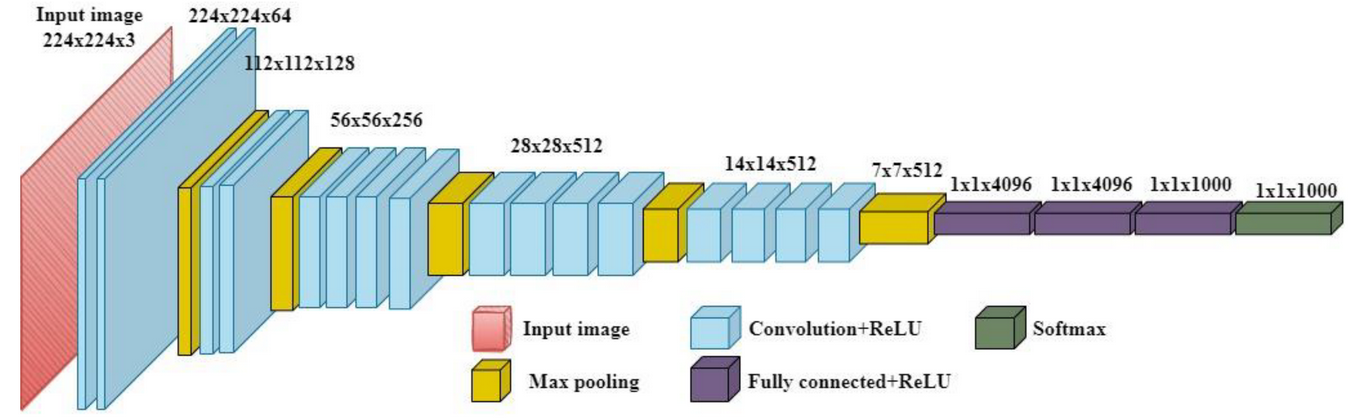
### *Рис.1: Модель на основі VGG-19 архітектури.*

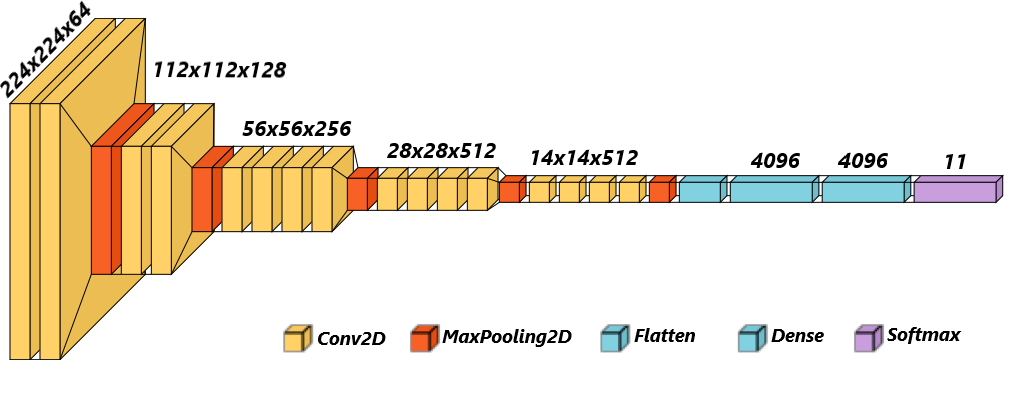
### *Рис.2: Модель на основі VGG-19 архітектури, використана у поданій роботі.*

## Loading and Preprocessing GTSRB dataset

GTSRB (German Traffic Sign Recognition Benchmark) даних представляє більше 50000 фотографій дорожніх знаків, які поділені на 43 класи. Зображення представлені у розмірі в межах 15х15 - 250х250 пікселів і подаються у форматі RGB. У поданій роботі було використано 10000 зображень для тренування та 6000 для тестування моделей. Усі зображення з наборів даних SVHN та GTSRB були нормалізовані та перетворені у формат 64х64 пікселі.

In [3]:
img_height = 64
img_width = 64
channels = 3

In [4]:
# Paths to gtsrb
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

In [5]:
def preprocess_gtsrb(data_dir, train_path, test_path):
    X_gtsrb = []
    y_gtsrb = []
    X_gtsrb_test = []
    y_gtsrb_test = []

    NUM_CATEGORIES = len(os.listdir(train_path)) # 43

    for i in range(NUM_CATEGORIES):
        path = data_dir + '/Train/' + str(i)
        images = os.listdir(path)

        for img in images:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((img_height, img_width))
            X_gtsrb.append(np.array(resize_image))
            y_gtsrb.append(10)   # 10 stands for redundant class

    # Test data
    test = pd.read_csv(data_dir + '/Test.csv')
    imgs = test["Path"].values

    for img in imgs:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((img_height, img_width))
        X_gtsrb_test.append(np.array(resize_image))
        y_gtsrb_test.append(10)   # 10 stands for redundant class
    
    # Changing the list to numpy array
    X_gtsrb = np.array(X_gtsrb)
    y_gtsrb = np.array(y_gtsrb)
    X_gtsrb_test = np.array(X_gtsrb_test)
    y_gtsrb_test = np.array(y_gtsrb_test)
    
    # Assuming type is bfloat16
    X_gtsrb = X_gtsrb.astype('bfloat16')   #COMMENTED 04.02
    X_gtsrb_test = X_gtsrb_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_gtsrb = X_gtsrb / 255
    X_gtsrb_test = X_gtsrb_test / 255
    
    return X_gtsrb[:10000], y_gtsrb[:10000], X_gtsrb_test[:6000], y_gtsrb_test[:6000]

In [6]:
X_gtsrb, y_gtsrb, X_gtsrb_test, y_gtsrb_test = preprocess_gtsrb(data_dir, train_path, test_path)

from IPython.display import clear_output
clear_output()

In [7]:
print(f"X_gtsrb shape: {X_gtsrb.shape}")
print(f"y_gtsrb shape: {y_gtsrb.shape}")
print(f"X_gtsrb_test shape: {X_gtsrb_test.shape}")
print(f"y_gtsrb_test shape: {y_gtsrb_test.shape}")

X_gtsrb shape: (10000, 64, 64, 3)
y_gtsrb shape: (10000,)
X_gtsrb_test shape: (6000, 64, 64, 3)
y_gtsrb_test shape: (6000,)


## Loading and Preprocessing SVHN dataset

Набір даних SVHN (Street View House Numbers), який представляє фотографії будинкових номерів,  містить 73257 зображень для тренування та 26032 для тестування моделі. Цей датасет є наближеним до MNIST, оскільки складається із зображень 10 класів цифр. Зображення в даному датасеті подаються з розміром 32х32 пікселі у форматі RGB. Для проведення досліджень буде використовуватись 50000 зображень для тренування та 15000 для тестування.

In [8]:
def preprocess_svhn(train_raw, test_raw):
    # Load images and labels
    X_svhn = np.array(train_raw['X'])
    X_svhn_test = np.array(test_raw['X'])

    y_svhn = train_raw['y']
    y_svhn_test = test_raw['y']
    
    # Fix the axes of the images
    X_svhn = np.moveaxis(X_svhn, -1, 0)
    X_svhn_test = np.moveaxis(X_svhn_test, -1, 0)
    
    y_svhn = np.squeeze(y_svhn)
    y_svhn_test = np.squeeze(y_svhn_test)
    
    # Assuming type is bfloat16
    X_svhn = X_svhn.astype('bfloat16')   #COMMENTED 04.02
    X_svhn_test = X_svhn_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_svhn = X_svhn / 255
    X_svhn_test = X_svhn_test / 255
    
    # Resize images from 32x32 to 64x64 (returns EagerTensor type)
    X_svhn = tf.image.resize_with_pad(
        image=X_svhn,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    X_svhn_test = tf.image.resize_with_pad(
        image=X_svhn_test,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    
    y_svhn = np.where(y_svhn != 10, y_svhn, 0)
    y_svhn_test = np.where(y_svhn_test != 10, y_svhn_test, 0)

    # Convert EagerTensor to numpy array
    X_svhn = X_svhn.numpy()
    X_svhn_test = X_svhn_test.numpy()
    
    return X_svhn[:50000], y_svhn[:50000], X_svhn_test[:15000], y_svhn_test[:15000]

In [9]:
# Load train and test data for svhn
train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [10]:
X_svhn, y_svhn, X_svhn_test, y_svhn_test = preprocess_svhn(train_raw, test_raw)

from IPython.display import clear_output
clear_output()

In [11]:
print(f"X_svhn shape: {X_svhn.shape}")
print(f"y_svhn shape: {y_svhn.shape}")
print(f"X_svhn_test shape: {X_svhn_test.shape}")
print(f"y_svhn_test shape: {y_svhn_test.shape}")

X_svhn shape: (50000, 64, 64, 3)
y_svhn shape: (50000,)
X_svhn_test shape: (15000, 64, 64, 3)
y_svhn_test shape: (15000,)


### Function to define VGG-19 Architecture

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

def get_vgg19_model():
    return keras.Sequential([
        # Convolutional base for feature extraction 
        # Block One
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape_svhn),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Two
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Three
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Four
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Five
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Head of dense (fully connected) layers for classification
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(num_of_classes, activation='softmax'),
    ])

## Concatenation of SVHN and GTSRB datasets

In [13]:
y_svhn = np.squeeze(y_svhn)
y_svhn_test = np.squeeze(y_svhn_test)

In [14]:
X = np.concatenate((X_svhn, X_gtsrb), axis=0)
y = np.concatenate((y_svhn, y_gtsrb), axis=0)

X_test = np.concatenate((X_svhn_test, X_gtsrb_test), axis=0)
y_test = np.concatenate((y_svhn_test, y_gtsrb_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X, y = shuffle(X, y)
X_test, y_test = shuffle(X_test, y_test)

In [15]:
print(f'Train: X={X.shape}, y={y.shape}')
print(f'Test: X={X_test.shape}, y={y_test.shape}')

Train: X=(60000, 64, 64, 3), y=(60000,)
Test: X=(21000, 64, 64, 3), y=(21000,)


## Building a model

In [16]:
num_of_classes = len(np.unique(y))
num_of_classes

11

Оскільки дані у prediction target подані як цілі числа [0, 10], які репрезентують відповідні цифри на фотографіях (classification), є два шляхи опрацювання та побудови моделі. З одного боку, можна залишити все як є та вважати, що ми працюємо з виконаним ordinal encoding. З іншого боку, можна використати onehot encoding, з допомогою якого буде створено 10 нових стовпців, кожен з яких буде представляти цифру. Таким чином кожна фотографія буде мітисти 10-елементний вектор, кожне значення якого буде вказувати яку цифру представляє фотографія. 

In [17]:
y = to_categorical(y)
y_test = to_categorical(y_test)

print(f'y_one_hot: train={y.shape}')

y_one_hot: train=(60000, 11)


In [18]:
input_shape_svhn = X.shape[1:]
input_shape_svhn

(64, 64, 3)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [20]:
vgg_19_model_onehot = get_vgg19_model()

In [21]:
vgg_19_model_onehot.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
vgg_19_model_onehot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [22]:
history_vgg19_onehot_gtsrb_and_svhn = vgg_19_model_onehot.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=5,
)

Epoch 1/5
750/750 [==============================] - 93s 102ms/step - loss: 2.3240 - accuracy: 0.1665 - val_loss: 2.3117 - val_accuracy: 0.1597
Epoch 2/5
750/750 [==============================] - 79s 105ms/step - loss: 2.1519 - accuracy: 0.2449 - val_loss: 1.7958 - val_accuracy: 0.3851
Epoch 3/5
750/750 [==============================] - 79s 106ms/step - loss: 0.9714 - accuracy: 0.6925 - val_loss: 0.5658 - val_accuracy: 0.8442
Epoch 4/5
750/750 [==============================] - 80s 106ms/step - loss: 0.4242 - accuracy: 0.8715 - val_loss: 0.3772 - val_accuracy: 0.8886
Epoch 5/5
750/750 [==============================] - 80s 106ms/step - loss: 0.2880 - accuracy: 0.9137 - val_loss: 0.3620 - val_accuracy: 0.8877


In [23]:
score_onehot_gtsrb_and_svhn = vgg_19_model_onehot.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_onehot_gtsrb_and_svhn[0])
print('Test score:', score_onehot_gtsrb_and_svhn[1])

print("CNN Error: %.2f%%" % (100-score_onehot_gtsrb_and_svhn[1]*100))

Test loss: 0.7144357562065125
Test score: 0.8221428394317627
CNN Error: 17.79%


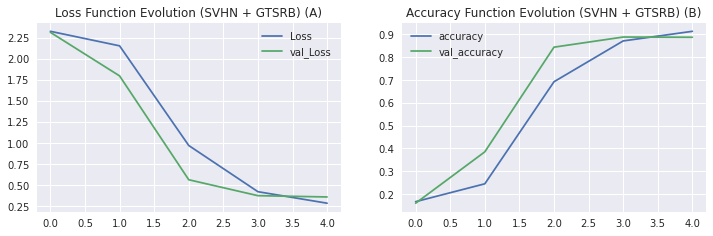

In [24]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_vgg19_onehot_gtsrb_and_svhn.history['loss'], label='Loss')
plt.plot(history_vgg19_onehot_gtsrb_and_svhn.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution (SVHN + GTSRB) (A)')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_vgg19_onehot_gtsrb_and_svhn.history['accuracy'], label='accuracy')
plt.plot(history_vgg19_onehot_gtsrb_and_svhn.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution (SVHN + GTSRB) (B)')
plt.legend()

## Prediction and Confusion Matrix
---

In [25]:
# GPU T4 x2, batch_size = 32 (default)
import time
start_time = time.time()

#Predict y_test values for comparison in confusion matrix (gtsrb + svhn, 11 classes)
y_test_pred = vgg_19_model_onehot.predict(X_test)

elapsed = time.time() - start_time

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (gtsrb + svhn dataset, 11 classes): {np.round(elapsed / len(X_test), 6)} sec.")

Inference time for all samples: 21.659041 sec.
Average inference time for 1 sample (gtsrb + svhn dataset, 11 classes): 0.001031 sec.


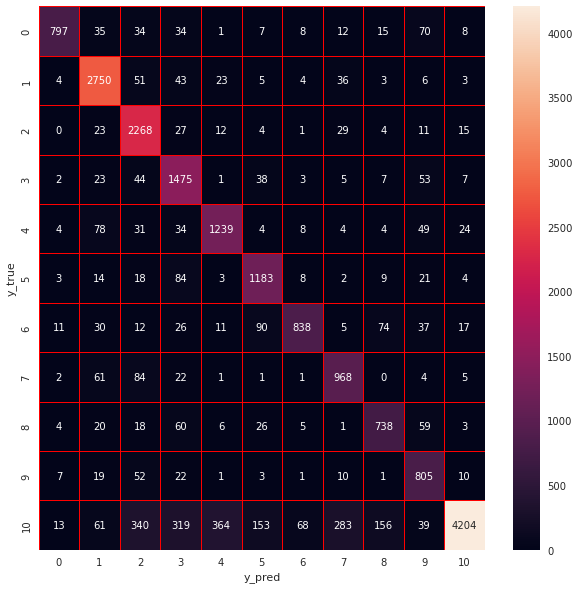

In [26]:
#Confusion matrix for svhn + gtsrb evaluation data
gtsrb_svhn_cm=confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(gtsrb_svhn_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [27]:
print(classification_report(y_test.argmax(axis=1), y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1021
           1       0.88      0.94      0.91      2928
           2       0.77      0.95      0.85      2394
           3       0.69      0.89      0.78      1658
           4       0.75      0.84      0.79      1479
           5       0.78      0.88      0.83      1349
           6       0.89      0.73      0.80      1151
           7       0.71      0.84      0.77      1149
           8       0.73      0.79      0.76       940
           9       0.70      0.86      0.77       931
          10       0.98      0.70      0.82      6000

    accuracy                           0.82     21000
   macro avg       0.80      0.84      0.81     21000
weighted avg       0.84      0.82      0.82     21000



### Other results representation
---

In [28]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
labels.append("10")

def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

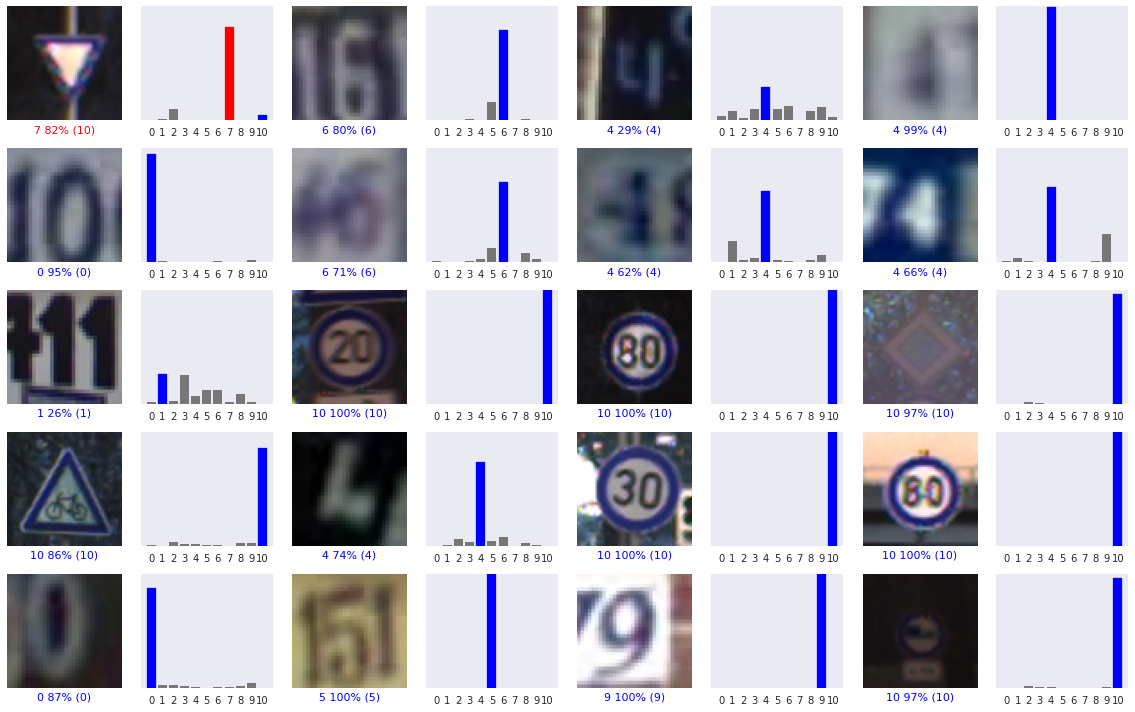

In [29]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
X_test = X_test.astype("float32")
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred[i+20], y_test[i+20], X_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i+20], y_test[i+20])
plt.tight_layout()
plt.show()